# Solar Power Generation – Support Vector Regression (SVR) Model

## Objective

The objective of this notebook is to build and evaluate a **Support Vector Regression (SVR)** model to predict **`power_generated`**, which represents the amount of solar energy produced (in Joules) during each 3-hour interval.

This is a **regression problem** because the target variable is continuous.  
The goal is to model how different environmental conditions influence solar power production.

SVR is a kernel-based regression technique that:

- Can model non-linear relationships between features and target
- Uses the concept of a “margin of tolerance” (epsilon) instead of minimizing raw prediction error
- Allows tuning of **C (regularization strength)**, **epsilon (error margin)**, and **gamma (kernel influence)**

### Input Features

The following environmental variables are used as predictors:

- `distance_to_solar_noon` – angular distance from solar noon (radians)  
- `temperature` – average daily temperature (°C)  
- `wind_direction` – wind direction in degrees (0–360)  
- `wind_speed` – average wind speed (m/s)  
- `sky_cover` – cloud coverage (0 = clear, 4 = fully covered)  
- `visibility` – visibility distance (km)  
- `humidity` – relative humidity (%)  
- `average_wind_speed_period` – average wind speed during the 3-hour measurement interval (m/s)  
- `average_pressure_period` – atmospheric pressure during the 3-hour measurement interval (inHg)

### Workflow of this Notebook

1. Load and inspect the dataset  
2. Handle missing values (if any)  
3. Define features (`X`) and target (`y`)  
4. Split the data into train and test sets  
5. Build an SVR model pipeline with scaling  
6. Tune hyperparameters (`C`, `epsilon`, `gamma`) using GridSearchCV  
7. Evaluate the model using MAE, RMSE, and R²  
8. Visualize Actual vs Predicted values  
9. Save the trained model (optional)


In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib


## 1. Load the Dataset

We load the original solar power generation dataset from the CSV file.  
This dataset contains 2920 rows (instances) and 10 columns (variables).


In [3]:
data_path = r"D:\DATA-SCIENCE\project\solarpowergeneration.csv"

df = pd.read_csv(data_path)

df.head()


,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


## 2. Basic Dataset Overview

In this step we check:

- Number of rows and columns  
- Column names  
- Data types  
- Missing values (if any)


In [4]:
print("Shape of the dataset:", df.shape)
print("\nColumn information:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape of the dataset: (2920, 10)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance-to-solar-noon       2920 non-null   float64
 1   temperature                  2920 non-null   int64  
 2   wind-direction               2920 non-null   int64  
 3   wind-speed                   2920 non-null   float64
 4   sky-cover                    2920 non-null   int64  
 5   visibility                   2920 non-null   float64
 6   humidity                     2920 non-null   int64  
 7   average-wind-speed-(period)  2919 non-null   float64
 8   average-pressure-(period)    2920 non-null   float64
 9   power-generated              2920 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 228.3 KB
None

Missing values per column:
distance-to-solar-noon         0
temperature              

## 3. Handling Missing Values

From the dataset overview, we found **one missing value** in the column  
`average-wind-speed-(period)`.

Since it is a numeric variable, we replace the missing value with the **median** of the column to avoid distortion caused by outliers.


In [5]:
df["average-wind-speed-(period)"] = df["average-wind-speed-(period)"].fillna(
    df["average-wind-speed-(period)"].median()
)

df.isna().sum()


distance-to-solar-noon         0
temperature                    0
wind-direction                 0
wind-speed                     0
sky-cover                      0
visibility                     0
humidity                       0
average-wind-speed-(period)    0
average-pressure-(period)      0
power-generated                0
dtype: int64

## 4. Rename Columns

We replace special characters (`-`, `(`, `)`) with underscores to ensure column names are compatible with scikit-learn pipelines.


In [7]:
df.columns = df.columns.str.replace("-", "_").str.replace("(", "").str.replace(")", "")
df.head()


,distance_to_solar_noon,temperature,wind_direction,wind_speed,sky_cover,visibility,humidity,average_wind_speed_period,average_pressure_period,power_generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


## 5. Define Features (X) and Target (y)

The target variable is:

- `power_generated`: energy produced in Joules for each 3-hour interval.

All other variables are used as predictors. We separate the dataset into:

- `X`: feature matrix (independent variables)  
- `y`: target vector (dependent variable)


In [8]:
target_col = "power_generated"

X = df.drop(columns=[target_col])
y = df[target_col]

X.shape, y.shape


((2920, 9), (2920,))

## 6. Train–Test Split

We split the dataset into:

- **Training set (80%)** → used to train and tune the model  
- **Test set (20%)** → used only for final evaluation

A fixed `random_state` is used to ensure that the split is reproducible.


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((2336, 9), (584, 9))

## 7. Build SVR Pipeline

SVR is highly sensitive to the scale of input features. Therefore, we apply:

1. **StandardScaler** to standardize the features  
2. **SVR** with an RBF kernel (default) to capture non-linear relationships

We create a pipeline so that scaling and the SVR model are applied together.


In [15]:
svr_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVR())
])

svr_pipeline


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0


## 8. Hyperparameter Tuning for SVR

Important SVR hyperparameters:

- `C`: regularization parameter (controls the trade-off between training error and model complexity)  
- `epsilon`: width of the epsilon-insensitive tube around the regression function  
- `gamma`: kernel coefficient for the RBF kernel (controls the influence range of data points)

We use **GridSearchCV** to search for a combination of hyperparameters that minimizes the mean squared error.


In [16]:
param_grid = {
    "model__C": [1, 10, 50, 100],
    "model__epsilon": [0.1, 0.2, 0.5],
    "model__gamma": ["scale", 0.01, 0.001]
}

grid_search = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=param_grid,
    cv=3,   # SVR can be computationally expensive
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'model__C': 100, 'model__epsilon': 0.5, 'model__gamma': 'scale'}
Best CV score (negative MSE): -64430871.23342035


## 9. Model Evaluation on Test Set


In [17]:
best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("SVR Performance on Test Set")
print("---------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


SVR Performance on Test Set
---------------------------
MAE  : 4451.4986
RMSE : 7212.2535
R²   : 0.5062


SVR achieved lower MAE than Ridge, but with higher RMSE and lower R², indicating weaker generalization performance. Ridge Regression remains the better-performing model for this dataset.

## 10. Actual vs Predicted Plot

To visually assess model performance, we compare the predicted values against the true `power_generated` values.

A well-performing regression model should produce points that lie close to the diagonal reference line  
(where **Predicted = Actual**). The farther the points deviate from this line, the larger the prediction error.


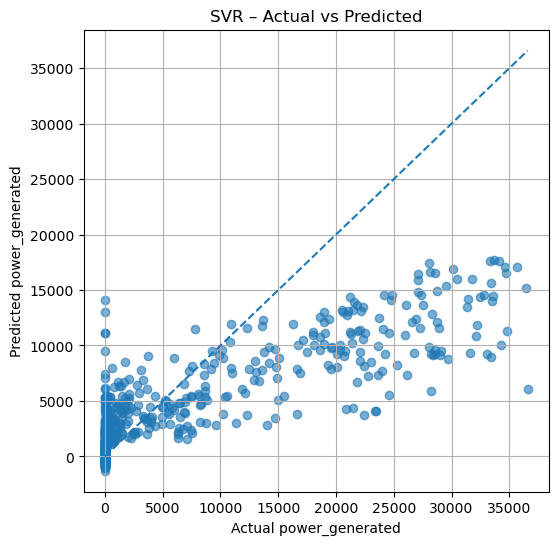

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual power_generated")
plt.ylabel("Predicted power_generated")
plt.title("SVR – Actual vs Predicted")
plt.grid(True)
plt.show()


## 11. Save the Trained SVR Model

We save the trained SVR model to disk so it can be reused later for prediction or deployment without needing retraining.


In [19]:
model_path = r"D:\DATA-SCIENCE\project\svr_model.pkl"
joblib.dump(best_svr, model_path)

print(f"Model saved to: {model_path}")


Model saved to: D:\DATA-SCIENCE\project\svr_model.pkl
